# Graph CNN and Permutation inviriance
This notebook contains extensions of the basic learning aggregate function approach. We will try to learn max() function by varying the dimension of latent space. 

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
import random
seed = 1387
random.seed(seed)
np.random.seed(seed)

We will asume we have 100 customers with varying number of orders. We will see if we can successfully learn the max of the order amount for every customer.

In [0]:
#The probabilities that the customer orders something:
probs = np.linspace(2, 50, 100)
orders = []
for customer_id, prob in enumerate(probs):
  num_orders = np.random.poisson(prob)
  orders += [[customer_id, abs(amount)] for amount in np.random.normal(100, 20, num_orders)]

orders = pd.DataFrame(orders, columns=['customer_id', 'order_amount'])

First we will do some exploratory data analysis. We will see the distribution of the max order amount among the customers.

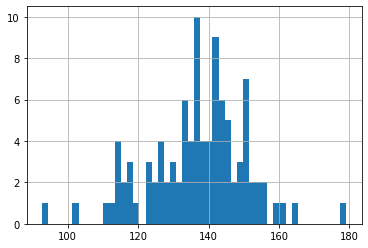

In [5]:
grouped_customers = orders.groupby('customer_id').agg({'order_amount': 'max'}) 
grouped_customers.order_amount.hist(bins=50);

In [6]:
grouped_customers = grouped_customers.reset_index()
grouped_customers.head()

,customer_id,order_amount
0,0,124.137100
1,1,114.322688
2,2,102.327380
3,3,92.735173
4,4,110.932746


In [7]:

from keras import backend as K 
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

Using TensorFlow backend.


In [0]:
import tensorflow as tf
import keras.layers as L

def train_minibatch(seq, latent_space_dimension, learning_rate=1E-3, num_epochs = 2000, sample_fraction = 0.1, verbose=False):
    'Train the neural network'
    
    
    tf.reset_default_graph()
    X = tf.placeholder('float', shape=(None,1), name='X')
    Y = tf.placeholder('float', shape=(None,1), name='Y')
    cid = tf.placeholder('int64', shape=(None), name='card_ids')
    
    #For this POC we use linear units. In reality, we should add non-linearity
    pre1 = L.Dense(64, activation="elu")(X)
    pre2 = L.Dense(128, activation="elu")(pre1)
    pre3 = L.Dense(latent_space_dimension, activation="elu")(pre2)
    
    #segment_sum() will do a group-by operation for us.
    reduced = tf.segment_sum(data=pre3, segment_ids=cid, name='segment_sum')
    
    post1 = L.Dense(64, activation='elu')(reduced)
    post2 = L.Dense(128, activation='elu')(post1)
    post3 = L.Dense(256, activation='elu')(post2)
    #Again using linear units
    predicted = L.Dense(1, activation=None)(post3)
    
    cost = tf.losses.mean_squared_error(labels=Y, predictions=predicted)

    r_squared = r2_keras(Y, predicted)
    
    #Using Adam optimizer here, even though I could not get optimal performance with it
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    train = optimizer.minimize(cost)
    
    init = tf.global_variables_initializer()
    
    losses = []
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            
            #The way we feed data is as follows:
            # 1. Take a sample of "cards" (grouped data)
            # 2. Create a numeric sequence number, becasue segment_sum() requires it
            # 3. Join with the data set to label each record of the sample with the sequence number
            cards = seq.sample(frac=sample_fraction)
            cards['sequence_number'] = range(cards.shape[0])
            merged = pd.merge(orders, cards, on='customer_id', how='inner').sort_values(by='sequence_number')
            
            x_value = merged.order_amount_x.values.reshape([-1,1])
            y_value = cards.order_amount.values.reshape([-1,1])
            card_ids = merged.sequence_number
            
            _ , minibatch_cost, r2_value, prediction_values = \
              sess.run([train, cost, r_squared, predicted], feed_dict={X: x_value, Y: y_value, cid: card_ids})
            losses.append(minibatch_cost)

            if verbose and epoch % 1000 == 0:
                print ("Cost after epoch %i: %f, R^2 is %f" % (epoch, minibatch_cost, r2_value))

    return losses, prediction_values

In [36]:
#Check if we can learn to count
#count_cards = pd.DataFrame(dummied.groupby('customer_id').count().purchase_amount)
losses, predictions = train_minibatch(grouped_customers, latent_space_dimension=500, 
                                      learning_rate=1E-3, num_epochs=40001, sample_fraction=0.5, verbose=True)
#plt.plot(losses);

Cost after epoch 0: 33619.304688, R^2 is -331.295227
Cost after epoch 1000: 89.127716, R^2 is 0.532251
Cost after epoch 2000: 52.573833, R^2 is 0.701442
Cost after epoch 3000: 78.377823, R^2 is 0.552219
Cost after epoch 4000: 88.847351, R^2 is 0.605079
Cost after epoch 5000: 61.930248, R^2 is 0.636346
Cost after epoch 6000: 38.807571, R^2 is 0.755275
Cost after epoch 7000: 44.269352, R^2 is 0.749114
Cost after epoch 8000: 63.332882, R^2 is 0.703017
Cost after epoch 9000: 14.726912, R^2 is 0.915783
Cost after epoch 10000: 28.504545, R^2 is 0.821205
Cost after epoch 11000: 3.435288, R^2 is 0.979198
Cost after epoch 12000: 1.664624, R^2 is 0.992348
Cost after epoch 13000: 1.507223, R^2 is 0.992144
Cost after epoch 14000: 1.546011, R^2 is 0.990933
Cost after epoch 15000: 129.024017, R^2 is -0.049392
Cost after epoch 16000: 15.578131, R^2 is 0.889465
Cost after epoch 17000: 10.231650, R^2 is 0.932671
Cost after epoch 18000: 11.742932, R^2 is 0.925244
Cost after epoch 19000: 1.852210, R^2 is

Now let us try to explore the model performance for different values of the latent space dimensionality

In [0]:
results = [[dimensionality, train_minibatch(grouped_customers, latent_space_dimension=dimensionality, 
        learning_rate=1E-3, num_epochs=20001, sample_fraction=0.5)] for dimensionality in [25, 50, 75, 100, 125, 150, 175, 200]]


In [0]:
results_df = pd.DataFrame([(dim, min(res[0])) for dim, res in results], columns=["dimension", "mse"])

In [45]:
results_df

,dimension,mse
0,25,0.183349
1,50,0.018074
2,75,0.036218
3,100,0.178824
4,125,0.029192
5,150,0.005710
6,175,0.015270
7,200,0.051442


In general, we get pretty low MSE. It seems that the neural network fits the data well. We can also observe that we get unexpected spike of MSE for 100-dimensional latent space. It is possible that the model overfits, because due to several hidden layers we have a lot of parameters for this model. Futher investigation is required to rune it, pick the best activation function and the model architecture


